In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

from modAL.disagreement import vote_entropy_sampling
from modAL.models import ActiveLearner, Committee

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from tqdm import tqdm
from collections import namedtuple



In [7]:
df = pd.read_csv("data/card_transdata.csv")

#Data transform

df['distance_from_home'] = (df['distance_from_home'] - np.mean(df['distance_from_home']))/np.std(df['distance_from_home'])
df['distance_from_last_transaction'] = (df['distance_from_last_transaction'] - np.mean(df['distance_from_last_transaction']))/np.std(df['distance_from_last_transaction'])
df['ratio_to_median_purchase_price'] = (df['ratio_to_median_purchase_price'] - np.mean(df['ratio_to_median_purchase_price']))/np.std(df['ratio_to_median_purchase_price'])

print(*df.columns.values)

#split to legit and fraud frames
legit, fraud = [x for _, x in df.groupby(df['fraud'] == 1)]

distance_from_home distance_from_last_transaction ratio_to_median_purchase_price repeat_retailer used_chip used_pin_number online_order fraud


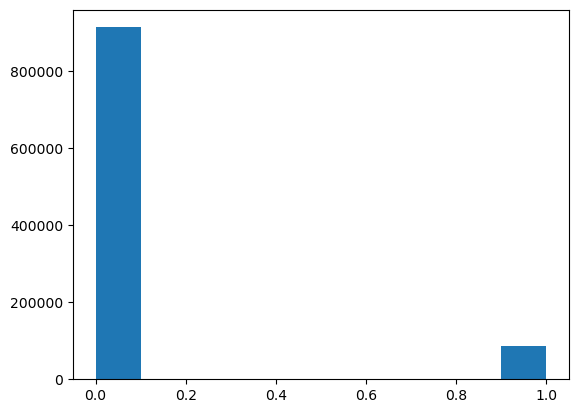

In [3]:
plt.hist(df['fraud'])
plt.show()

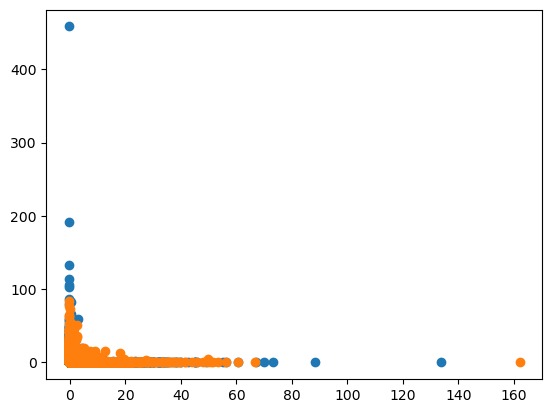

In [4]:
plt.scatter(legit['distance_from_home'], legit['distance_from_last_transaction'])
plt.scatter(fraud['distance_from_home'], fraud['distance_from_last_transaction'])
plt.show()

In [8]:
#PC transform data
n_comp = 7
pca = PCA(n_components=n_comp)
pca.fit(df.loc[:, df.columns != 'fraud'])

legit, fraud = pca.transform(legit.loc[:, legit.columns != 'fraud']), pca.transform(fraud.loc[:, fraud.columns != 'fraud'])

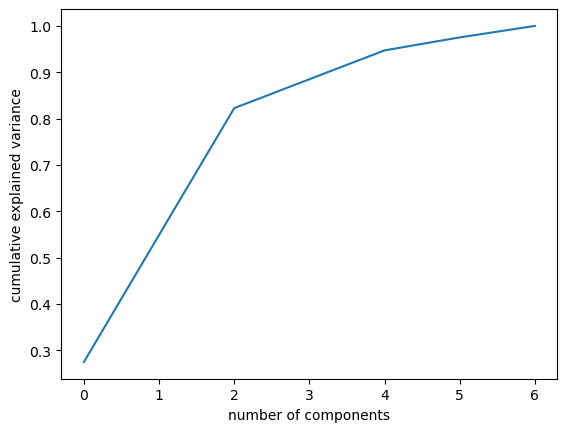

In [9]:
#plot explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

(250, 7)


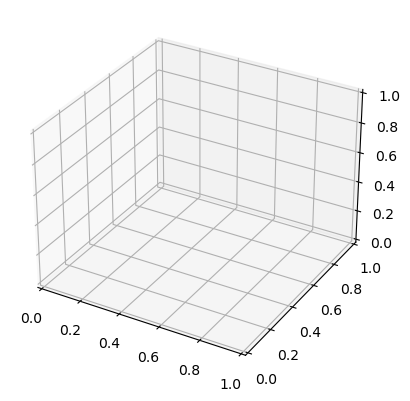

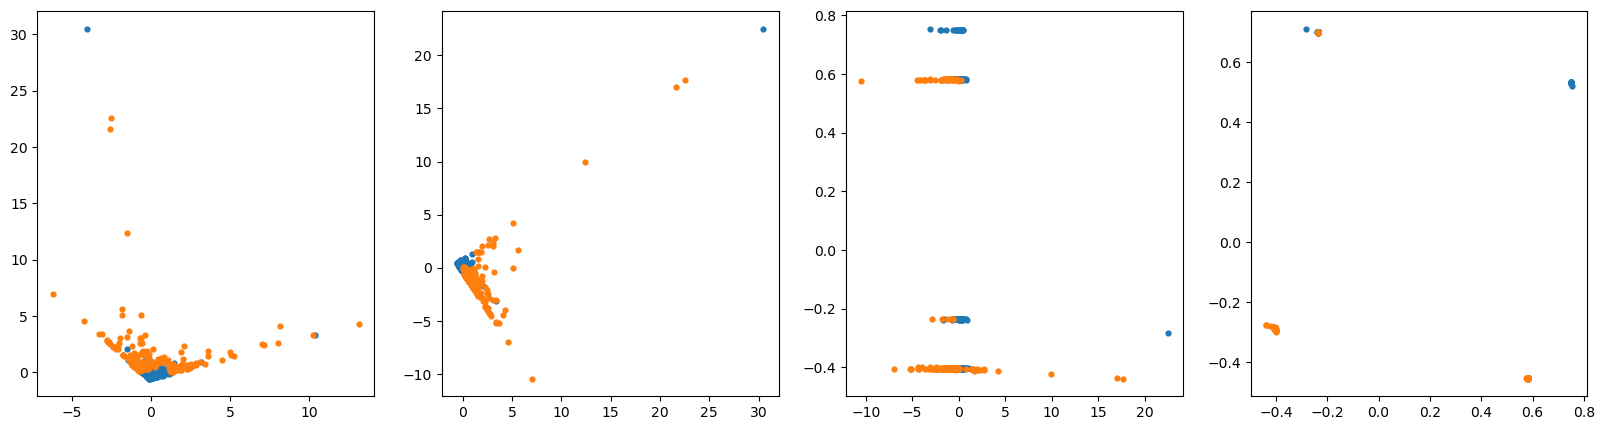

In [10]:

fig = plt.figure()

legit_lim = legit[:250]
fraud_lim = fraud[:250]

print(legit_lim.shape)

ax = fig.add_subplot(projection='3d')

start = 1
pc = [start+i for i in range(2)]

plots = 4

fig, axs = plt.subplots(1, plots, figsize=(5*plots, 5))

for i in range(plots):
    #reduce scatter size
    axs[i].scatter(legit_lim.T[i], legit_lim.T[i+1], s=12)
    axs[i].scatter(fraud_lim.T[i], fraud_lim.T[i+1], s=12)

plt.show()

In [11]:

y = df['fraud'].to_numpy()
X = df.drop('fraud', axis='columns').to_numpy()
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2,shuffle=True)
SEED = 58 # Set our RNG seed for reproducibility.

#count 1 in y_train
print("1 in y_train: ", np.count_nonzero(y_train == 0))

print(len(y_train))
n_queries = 100 # You can lower this to decrease run time

# You can increase this to get error bars on your evaluation.
# You probably need to use the parallel code to make this reasonable to compute
n_repeats = 1

permutations=[np.random.permutation(X_train.shape[0]) for _ in range(n_repeats)]

ResultsRecord = namedtuple('ResultsRecord', ['estimator', 'query_id', 'score'])

1 in y_train:  729950
800000


In [14]:
random_results = []

ModelClass=LogisticRegression

n_start = 5

for i_repeat in range(n_repeats):
    start_points = permutations[i_repeat][:n_start]
    selected_points = start_points
    random_learner = ModelClass()
    for i_query in tqdm(range(1,n_queries)):
        query_indices=permutations[i_repeat][:n_start+i_query]
        
        #if there is no 1 or 0 in y_train
        if np.count_nonzero(y_train[query_indices] == 1) == 0:
            index = np.where(y_train == 1)[0][0]
            query_indices[0] = index
        if np.count_nonzero(y_train[query_indices] == 0) == 0:
            index = np.where(y_train == 0)[0][0]
            query_indices[0] = index
        
        random_learner = random_learner.fit(X=X_train[query_indices, :], y=y_train[query_indices])
        random_score = random_learner.score(X_test, y_test)
        
        random_results.append(ResultsRecord('random', i_query, random_score))


100%|██████████| 99/99 [00:06<00:00, 16.29it/s]

99


c:\Users\lucas\miniconda3\envs\02463\lib\site-packages\matplotlib\axes\_base.py:2539: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


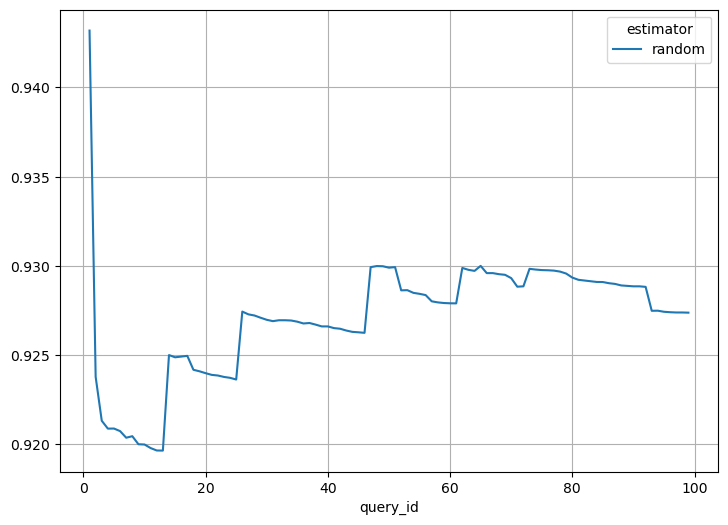

In [15]:
df_results = pd.DataFrame(random_results)

df_results_mean=df_results.groupby(['estimator','query_id']).mean()
df_results_std=df_results.groupby(['estimator','query_id']).std()

df_mean=df_results_mean.reset_index().pivot(index='query_id', columns='estimator', values='score')
df_std=df_results_std.reset_index().pivot(index='query_id', columns='estimator', values='score')

df_mean.plot(figsize=(8.5,6), yerr=df_std)
plt.grid('on')